# Fine-Grained Image Classification

In [8]:
!nvidia-smi

Fri Dec 22 17:56:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0                9W /  N/A|    425MiB /  4096MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Import Packages


In [9]:
# !pip install tqdm
# !pip install pytorch 
# !pip install torchvision
# !pip install torchensemble

In [10]:
import os
import numpy as np
from PIL import Image
import glob
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder

In [11]:
myseed = 666
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
# torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(myseed)
    torch.cuda.manual_seed_all(myseed)

### Transforms

In [12]:
train_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# train_tfm = transforms.Compose([
#     transforms.RandomResizedCrop(448),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90, interpolation=transforms.InterpolationMode.BICUBIC),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                             std=[0.229, 0.224, 0.225]),
# ])

# test_tfm = transforms.Compose([
#     transforms.Resize(int(448/0.875)),
#     transforms.CenterCrop(448),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.485, 0.456, 0.406),
#                             std=(0.229, 0.224, 0.225)),
# ])


### Datasets

In [13]:
# class TrainingDataset(Dataset):
#     def __init__(self, img_dir, transform=None):
#         """
#         data
#         ├── train
#         |   ├── class1
#         |   |   ├── xxxxx.jpg
#         |   |   ├── ...
#         |   |   └── yyyyy.jpg
#         |   |
#         |   ├── ...
#         """
#         self.img_dir = img_dir
#         self.transform = transform
#         self.images = []
#         self.labels = []
#         self.names = []

#         for i, class_dir in enumerate(glob.glob(f"{self.img_dir}/*")):
#             images = glob.glob(f"{class_dir}/*")
#             self.images += images
#             self.labels += [i] * len(images)
#             self.names += [os.path.basename(image)[:-4] for image in images]

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = self.transform(Image.open(self.images[idx]))
#         label = self.labels[idx]
#         return image, label


class TestingDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        data
        ├── test
        |   ├── xxxxx.jpg
        |   ├── ...
        |   └── yyyyy.jpg
        """
        self.img_dir = img_dir
        self.transform = transform
        self.images = []
        self.names = []

        self.images = sorted(glob.glob(f"{self.img_dir}/*"))
        self.names = [os.path.basename(image)[:-4] for image in self.images]

    def __len__(self):
        return len(self.images)
    
    def __getnames__(self):
        return self.names
    
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        return image

Total training data: 9588


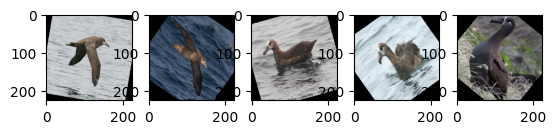

Total testing data: 2000
Total validation data: 200


In [14]:
train_set = ImageFolder("../data/train", train_tfm)
test_set = TestingDataset("../data/test", test_tfm)
valid_set = ImageFolder("../data/validation", test_tfm)

print(f"Total training data: {train_set.__len__()}")

# img, label = train_set.__getitem__(0)
# plt.imshow(img.permute(1, 2, 0))
# plt.show()

for i in range(5):
    img, _ = train_set.__getitem__(i)
    plt.subplot(1, 5, i+1)
    plt.imshow(img.permute(1, 2, 0))
plt.show()


print(f"Total testing data: {test_set.__len__()}")
# img = test_set.__getitem__(0)
# print(test_set.__getnames__()[0])
# plt.imshow(img.permute(1, 2, 0))
# plt.show()

print(f"Total validation data: {valid_set.__len__()}")

### Models

In [15]:
import torch.nn.functional as F


class Attention(torch.nn.Module):
    """
    Attention block for CNN model.
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(Attention, self).__init__()

        self.conv_depth = torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, groups=in_channels)
        self.conv_point = torch.nn.Conv2d(out_channels, out_channels, kernel_size=(1, 1))
        self.bn = torch.nn.BatchNorm2d(out_channels, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.activation = torch.nn.Tanh()

    def forward(self, inputs):
        x, output_size = inputs
        x = F.adaptive_max_pool2d(x, output_size=output_size)
        x = self.conv_depth(x)
        x = self.conv_point(x)
        x = self.bn(x)
        x = self.activation(x) + 1.0

        return x

In [16]:
class Resnet(nn.Module):
    def __init__(self, num_classes=200):
        super(Resnet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(2048, num_classes)

        self.att1 = Attention(64, 256, (3, 5), (1, 2))
        self.att2 = Attention(256, 512, (5, 3), (2, 1))
        self.att3 = Attention(512, 1024, (3, 5), (1, 2))
        self.att4 = Attention(1024, 2048, (5, 3), (2, 1))

        self.att1.bn.weight.data.zero_()
        self.att1.bn.bias.data.zero_()
        self.att2.bn.weight.data.zero_()
        self.att2.bn.bias.data.zero_()
        self.att3.bn.weight.data.zero_()
        self.att3.bn.bias.data.zero_()
        self.att4.bn.weight.data.zero_()
        self.att4.bn.bias.data.zero_()

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x_a = x.clone()
        x = self.resnet.layer1(x)
        x = x * self.att1((x_a, x.shape[-2:]))

        x_a = x.clone()
        x = self.resnet.layer2(x)
        x = x * self.att2((x_a, x.shape[-2:]))

        x_a = x.clone()
        x = self.resnet.layer3(x)
        x = x * self.att3((x_a, x.shape[-2:]))

        x_a = x.clone()
        x = self.resnet.layer4(x)
        x = x * self.att4((x_a, x.shape[-2:]))

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)

        return x

### Configurations

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 16
epochs = 80

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)  

model = Resnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Start Training

In [18]:
best_acc = 0.0

for epoch in range(epochs):

    model.train()
    train_loss = []
    train_accs = []

    with tqdm(total=len(train_loader), unit="batch") as tqdm_bar:
        tqdm_bar.set_description(f"Epoch {epoch+1:03d}/{epochs}")
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            acc = (logits.argmax(dim=1) == labels).float().mean()
            train_accs.append(acc)
            tqdm_bar.set_postfix(loss=f"{sum(train_loss)/len(train_loss):.5f}", acc=f"{sum(train_accs)/len(train_accs):.5f}", val_loss=0.0, val_acc=0.0)
            tqdm_bar.update(1)

        scheduler.step()

        tqdm_bar.set_postfix(loss=f"{sum(train_loss)/len(train_loss):.5f}", acc=f"{sum(train_accs)/len(train_accs):.5f}", val_loss=0.0, val_acc=0.0)

        model.eval()
        valid_loss = []
        valid_accs = []

        for i, (images, labels) in enumerate(valid_loader):
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                logits = model(images)
                loss = criterion(logits, labels)

            valid_loss.append(loss.item())
            acc = (logits.argmax(dim=1) == labels).float().mean()
            valid_accs.append(acc)
        
        tqdm_bar.set_postfix(loss=f"{sum(train_loss)/len(train_loss):.5f}", acc=f"{sum(train_accs)/len(train_accs):.5f}", val_loss=f"{sum(valid_loss)/len(valid_loss):.5f}", val_acc=f"{sum(valid_accs)/len(valid_accs):.5f}")

        if sum(valid_accs)/len(valid_accs) > best_acc:
            best_acc = sum(valid_accs)/len(valid_accs)
            torch.save(model.state_dict(), f"resnet50_attention.pth")

        tqdm_bar.close()


Epoch 014/80:  86%|████████▌ | 513/600 [03:49<00:38,  2.23batch/s, acc=0.89218, loss=0.46008, val_acc=0, val_loss=0]


KeyboardInterrupt: 

### Inference

In [ ]:
import pandas as pd


model = Resnet().to(device)
model.load_state_dict(torch.load("resnet50_attention.pth"))
model.eval()

predictions = []
with torch.no_grad():
    for i, images in enumerate(tqdm(test_loader)):
        images = images.to(device)
        logits = model(images)
        predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())



c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 125/125 [00:16<00:00,  7.76it/s]


In [ ]:
class_dic = {}
for i, class_dir in enumerate(train_set.classes):
    class_dic[i] = os.path.basename(class_dir)

predictions = [class_dic[pred] for pred in predictions]

submission = pd.DataFrame({"id": test_set.__getnames__(), "label": predictions})
submission.to_csv("../submission_attention.csv", index=False)